<a href="https://colab.research.google.com/github/nicolasViniegraa/porfolio/blob/main/diabetes_prediction/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise we'll develop several ML classification algorithms to predict whether a patient will have diabetes based on its conditions

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

The dataset was obtained from Kaggle, you can access to it with the following link:

https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

# Data Analysis

---



---



In [5]:
data = pd.read_csv('diabetes_prediction_dataset.csv')

data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


We have the following variables:

Gender: The gender of the patient <br>
Age: The age of the patient: <br>
Hypertension: 1 if the patient has hypertension, 0 if not <br>
Heart_disease: 1 if the patient has a heart_disease, 0 if not <br>
Smoking_history: The state of the patient related to smoking <br>
Bmi: Patient's body mass index <br>
HbA1c_level: Blood test that measures patient's average blood sugar levels over the past 3 months <br>
Diabetes: 1 if patient has diabetes, 0 if not (label) <br>

In [7]:
data.value_counts("diabetes")

diabetes
0    91500
1     8500
dtype: int64

In [8]:
data = data.dropna()

In [9]:
data.value_counts("diabetes")

diabetes
0    91500
1     8500
dtype: int64

Counting the amount of patients that have diabetes and those who don't we see that there is a disproportion between one case and the other, there are almost 10 times of records with patients that don't have diabetes, compared to those who have diabetes

Next we'll plot some graphs to understand more the data we are working with

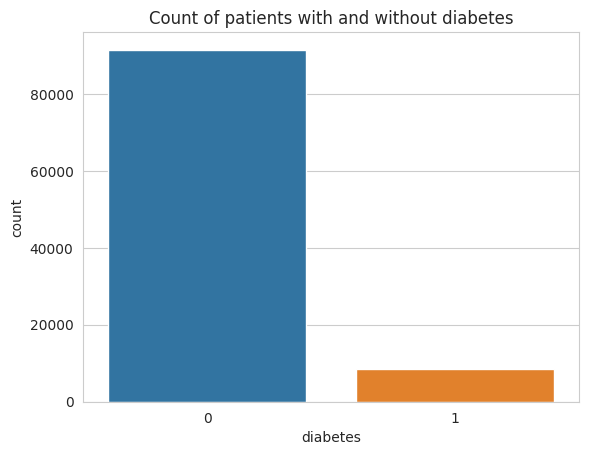

In [10]:
plt.title('Count of patients with and without diabetes')
sns.countplot(data=data, x='diabetes');

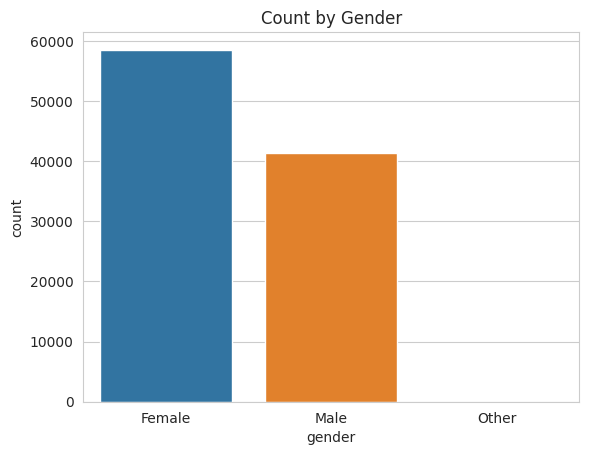

In [11]:
plt.title('Count by Gender')
sns.countplot(data=data, x='gender');

<Axes: title={'center': 'Age distribution'}, xlabel='age', ylabel='Count'>

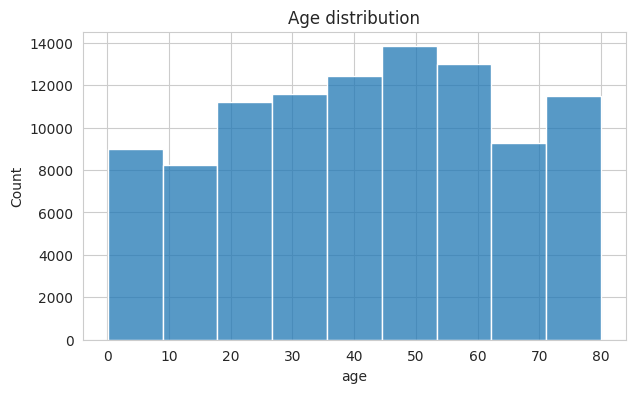

In [12]:
fig, axes = plt.subplots(1, figsize=(7,4), squeeze=False)
plt.title("Age distribution")
sns.histplot(data['age'], bins=9, ax=axes[0, 0])


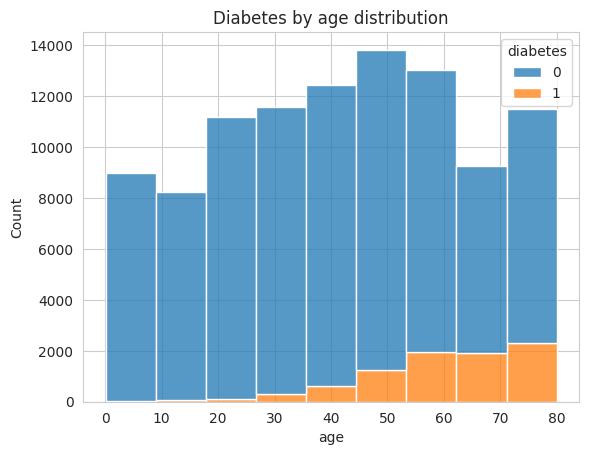

In [13]:
plt.title("Diabetes by age distribution")
sns.histplot(data=data, x='age', bins=9, hue='diabetes', multiple="stack");

<ipython-input-16-09a38d098661>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


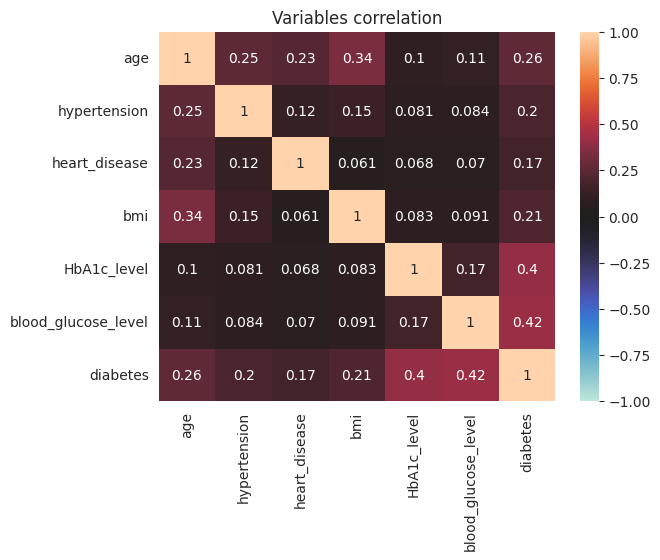

In [16]:
corr = data.corr()
plt.title("Variables correlation")
sns.heatmap(corr, vmin=-1, center=0, vmax=1, annot=True);

We can see in the correlation graph that there aren't variables that have high correlation enough between each other to consider dropping one of them. <br>

Also there isn't any variable that has a negative correlation with "Diabetes" to also considering dropping that variable <br>

Given these results, we'll keep all the variables for the creation of our models

# **Preprocessing**

---



---



In [25]:
data_without_outliers = data[(np.abs(stats.zscore(data['bmi'])) < 3)]
# data_without_outliers = data_without_outliers[(np.abs(stats.zscore(data_without_outliers['HbA1c_level'])) < 3)]
# data_without_outliers = data_without_outliers[(np.abs(stats.zscore(data_without_outliers['blood_glucose_level'])) < 3)]

We remove only the outliers from the "Bmi" variable, because after testing and removing outliers from other variables, I reached to models with lower efficiency because many of those outliers are cases with positive diabetes, so by reducing the current small amount of positive diabetes, the models performance drop. So for this case we are only removing outliers from "Bmi" variable

In [26]:
data_without_outliers.value_counts("diabetes")

diabetes
0    90572
1     8134
dtype: int64

In [27]:
#One hot encode categorical variables
data_with_dummies = pd.get_dummies(data_without_outliers, drop_first = True)

In [28]:
#split data in X variables and y variable
X_data = data_with_dummies.drop('diabetes', axis=1)
y_data = data_with_dummies['diabetes']

In [29]:
X_data

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,0,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,1,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0,0,0,0,0,0,0
99996,2.0,0,0,17.37,6.5,100,0,0,0,0,0,0,0
99997,66.0,0,0,27.83,5.7,155,1,0,0,0,1,0,0
99998,24.0,0,0,35.42,4.0,100,0,0,0,0,0,1,0


In [30]:
#normalize data 
scaler = StandardScaler()
scaler.fit(X_data)
scaled_data = scaler.transform(X_data)

In [31]:
scaled_data

array([[ 1.68821222, -0.28178524,  4.93835455, ..., -0.32014182,
         1.3626823 , -0.26194816],
       [ 0.53789239, -0.28178524, -0.2024966 , ..., -0.32014182,
        -0.73384677, -0.26194816],
       [-0.61242744, -0.28178524, -0.2024966 , ..., -0.32014182,
         1.3626823 , -0.26194816],
       ...,
       [ 1.06880923, -0.28178524, -0.2024966 , ...,  3.12361565,
        -0.73384677, -0.26194816],
       [-0.78939972, -0.28178524, -0.2024966 , ..., -0.32014182,
         1.3626823 , -0.26194816],
       [ 0.6706216 , -0.28178524, -0.2024966 , ..., -0.32014182,
        -0.73384677, -0.26194816]])

Since we are working with data that has a big disproportion between one class and the other (almost 1 to 10), we will be sampling the data for train and test with the stratified sampling method, so we can mantain the same proportion of each class both in the train and test sets

In [32]:
#Split data into train and test groups
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

y_data = np.array(y_data)

for train_index, test_index in skf.split(scaled_data, y_data):
    X_train, X_test = scaled_data[train_index], scaled_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

# **Models creation and evaluation**

---



---



## Logistic Regression

In [33]:
log_model = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

y_pred = log_model.predict(X_test)

Accuracy: 96.09
F1 score: 72.66
Recall: 63.1
Precision: 85.64
R2 Score: 48.26




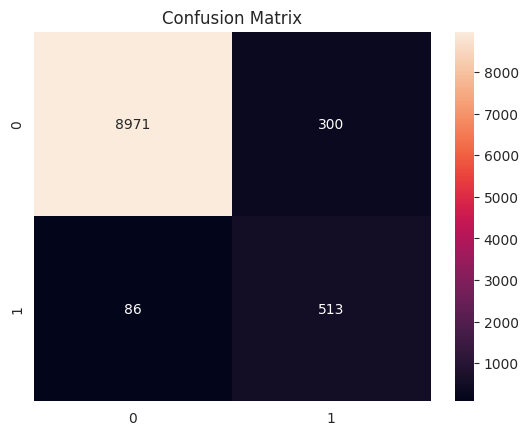

In [38]:
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
print('F1 score:', round(metrics.f1_score(y_test, y_pred) * 100, 2))
print('Recall:', round(metrics.recall_score(y_test, y_pred) * 100, 2))
print('Precision:', round(metrics.precision_score(y_test, y_pred) * 100, 2))
print('R2 Score:', round(metrics.r2_score(y_test, y_pred) * 100, 2))
print("\n")
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(y_pred, y_test), annot=True, fmt='g');

## K Nearest Neighbors

---



---



In [46]:
knn_model = KNeighborsClassifier(n_neighbors=8).fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

Accuracy: 96.35
F1 score: 72.64
Recall: 58.79
Precision: 95.03
R2 Score: 51.74




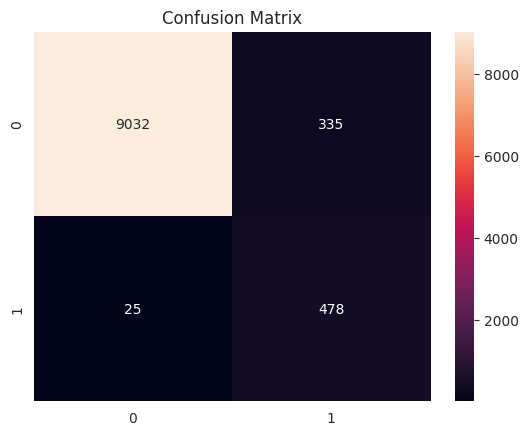

In [47]:
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
print('F1 score:', round(metrics.f1_score(y_test, y_pred) * 100, 2))
print('Recall:', round(metrics.recall_score(y_test, y_pred) * 100, 2))
print('Precision:', round(metrics.precision_score(y_test, y_pred) * 100, 2))
print('R2 Score:', round(metrics.r2_score(y_test, y_pred) * 100, 2))
print("\n")
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(y_pred, y_test), annot=True, fmt='g');

## Decision Tree Classifier

---



---



In [48]:
dt_model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

Accuracy: 95.31
F1 score: 72.16
Recall: 73.8
Precision: 70.59
R2 Score: 37.94




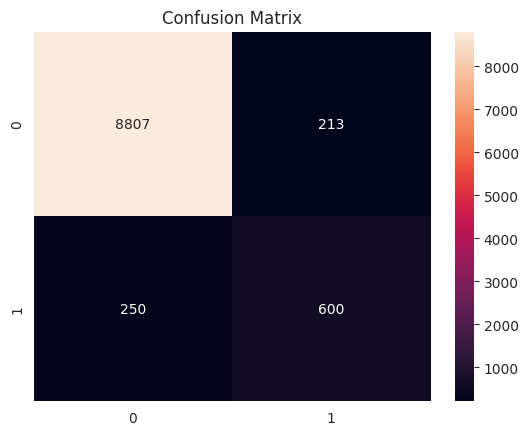

In [49]:
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
print('F1 score:', round(metrics.f1_score(y_test, y_pred) * 100, 2))
print('Recall:', round(metrics.recall_score(y_test, y_pred) * 100, 2))
print('Precision:', round(metrics.precision_score(y_test, y_pred) * 100, 2))
print('R2 Score:', round(metrics.r2_score(y_test, y_pred) * 100, 2))
print("\n")
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(y_pred, y_test), annot=True, fmt='g');

## Random Forest

---



---



In [50]:
rf_model = RandomForestClassifier(random_state=2, max_depth=5, criterion='entropy').fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

Accuracy: 97.41
F1 score: 81.31
Recall: 68.51
Precision: 100.0
R2 Score: 65.69




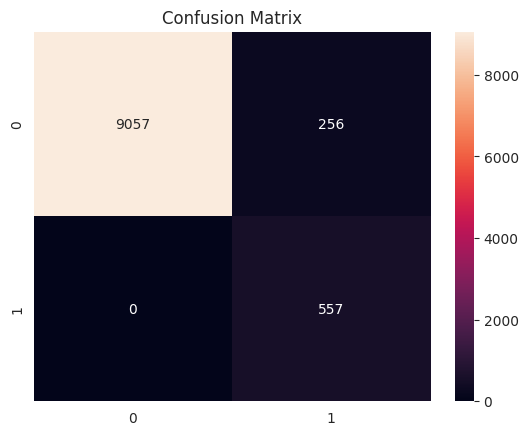

In [51]:
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
print('F1 score:', round(metrics.f1_score(y_test, y_pred) * 100, 2))
print('Recall:', round(metrics.recall_score(y_test, y_pred) * 100, 2))
print('Precision:', round(metrics.precision_score(y_test, y_pred) * 100, 2))
print('R2 Score:', round(metrics.r2_score(y_test, y_pred) * 100, 2))
print("\n")
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(y_pred, y_test), annot=True, fmt='g');

## Support Vector Machine

---



---



In [52]:
svc_model = SVC(random_state=2, kernel='linear' ).fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

Accuracy: 96.15
F1 score: 71.43
Recall: 58.43
Precision: 91.88
R2 Score: 49.06




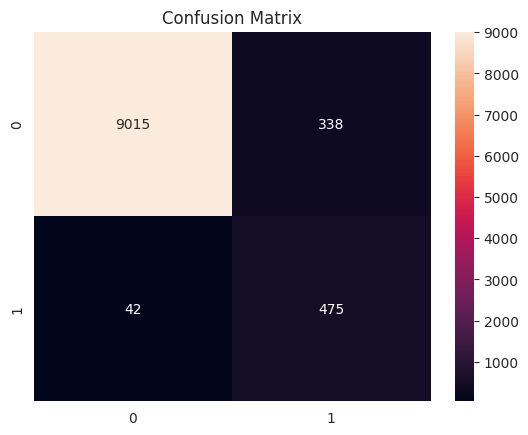

In [53]:
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
print('F1 score:', round(metrics.f1_score(y_test, y_pred) * 100, 2))
print('Recall:', round(metrics.recall_score(y_test, y_pred) * 100, 2))
print('Precision:', round(metrics.precision_score(y_test, y_pred) * 100, 2))
print('R2 Score:', round(metrics.r2_score(y_test, y_pred) * 100, 2))
print("\n")
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(y_pred, y_test), annot=True, fmt='g');

## Ada Boost Classifier

---


---




In [54]:
ab_model = AdaBoostClassifier(random_state=2).fit(X_train, y_train)

y_pred = ab_model.predict(X_test)

Accuracy: 97.33
F1 score: 81.12
Recall: 69.74
Precision: 96.92
R2 Score: 64.61




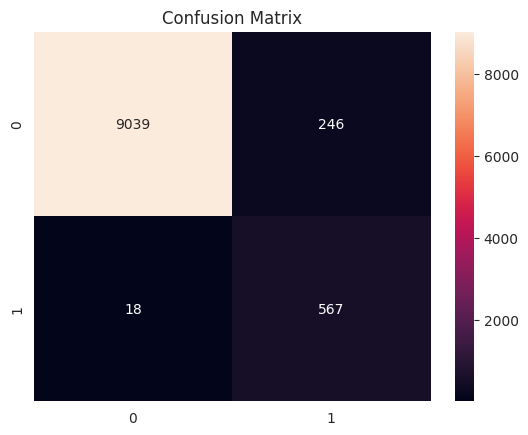

In [55]:
print('Accuracy:', round(metrics.accuracy_score(y_test, y_pred) * 100, 2))
print('F1 score:', round(metrics.f1_score(y_test, y_pred) * 100, 2))
print('Recall:', round(metrics.recall_score(y_test, y_pred) * 100, 2))
print('Precision:', round(metrics.precision_score(y_test, y_pred) * 100, 2))
print('R2 Score:', round(metrics.r2_score(y_test, y_pred) * 100, 2))
print("\n")
plt.title("Confusion Matrix")
sns.heatmap(metrics.confusion_matrix(y_pred, y_test), annot=True, fmt='g');

After developing and testing each model, we conclude that the model that has the best performance is Random Forest, because it predicted correctly all the positive diabetes cases, which are the most important case for this exercise.

Since we are working with a health exercise, it's more important to predict correctly positive diabetes cases, than correct negative cases. So, as we can see in the confusion matrices, Random Forest doesn't have false negatives, which means that all the tests in which the patient has diabetes, the model predicted correctly that the patient has diabetes.

The other models didn't have a great performance, we could highlight Ada Boost Classifier and K Nearest Neighbors which also have a high precision, but the best model is Random Forest